In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from tensorflow.keras.layers import GlobalAveragePooling1D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2024-02-28 14:22:28.387269: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-28 14:22:28.455152: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-28 14:22:28.455339: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-28 14:22:28.458268: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-28 14:22:28.475422: I tensorflow/core/platform/cpu_feature_guar

In [2]:
seed = 13
tf.random.set_seed(seed)
np.random.seed(seed)

In [3]:
train_df = pd.DataFrame({"file" : os.listdir("/home/kkyu/amr_ws/DL/data/shape_figure/train")})
train_df["label"] = train_df["file"].apply(lambda x: x.split(".")[0])
train_df["label"] = train_df["label"].str.split("_").str.get(0)

train_df

,file,label
0,star_27.jpg,star
1,star_799.jpg,star
2,rec_666.jpg,rec
3,cir_428.jpg,cir
4,rec_1000036.jpg,rec
...,...,...
796,tri_37.jpg,tri
797,cir_435.jpg,cir
798,tri_540.jpg,tri
799,cir_27.jpg,cir


In [4]:
test_df = pd.DataFrame({"file" : os.listdir("/home/kkyu/amr_ws/DL/data/shape_figure/test")})

test_df.head()

,file
0,183.jpg
1,107.jpg
2,149.jpg
3,111.jpg
4,100001.jpg


In [5]:
from sklearn.model_selection import train_test_split

train_data, val_data = train_test_split(train_df,
                                        test_size = 0.2,
                                        stratify = train_df["label"],
                                        
                                        random_state = 13)

In [6]:
train_datagen = ImageDataGenerator(
    rotation_range = 15,
    horizontal_flip = True,
    preprocessing_function = preprocess_input
)
val_datagen = ImageDataGenerator(preprocessing_function= preprocess_input)

In [7]:
FILES = "/home/kkyu/amr_ws/DL/data/shape_figure/train"
batch_size = 64
train_generator = train_datagen.flow_from_dataframe(
    dataframe = train_data,
    directory = FILES,
    x_col = "file",
    y_col = "label",
    class_mode = "categorical",
    target_size = (224, 224),
    batch_size = batch_size,
    seed = 13
)

Found 640 validated image filenames belonging to 4 classes.


In [8]:
val_generator = val_datagen.flow_from_dataframe(
    dataframe = val_data,
    directory = FILES,
    x_col = "file",
    y_col = "label",
    class_mode = "categorical",
    target_size = (224, 224),
    batch_size = batch_size,
    seed = 13,
    shuffle = False
)

Found 161 validated image filenames belonging to 4 classes.


In [9]:
base_model = VGG16(
    weights = "imagenet",
    input_shape = (224, 224, 3),
    include_top = False
)

2024-02-28 14:22:33.296864: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2024-02-28 14:22:33.296927: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: kkyu
2024-02-28 14:22:33.296935: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: kkyu
2024-02-28 14:22:33.297369: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: 535.161.7
2024-02-28 14:22:33.297422: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: 535.154.5
2024-02-28 14:22:33.297428: E external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:244] kernel version 535.154.5 does not match DSO version 535.161.7 -- cannot find working devices in this configuration


In [10]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [11]:
for layers in base_model.layers:
    layers.trainable = False

base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [12]:
from keras.layers import GlobalAveragePooling2D


def vgg16_pretrained():

    model = Sequential(
        [
            base_model,
            GlobalAveragePooling2D(),
            Dense(100, activation = "relu"),
            Dropout(0.4),
            Dense(64, activation = "relu"),
            Dense(4, activation = "softmax")
        ]
    )

    return model

In [13]:
tf.keras.backend.clear_session()

In [14]:
model = vgg16_pretrained()
model.compile(loss = "categorical_crossentropy",
              optimizer = "adam",
              metrics = "accuracy")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 100)               51300     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                6464      
                                                                 
 dense_2 (Dense)             (None, 4)                 260       
                                                        

In [15]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor = "val_accuracy",
    patience = 2,
    verbose = 1,
    factor = 0.5,
    min_lr = 0.000000001
)

In [16]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = "val_accuracy",
    patience = 5,
    verbose = 1,
    mode = "max"
)

In [17]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    monitor = "val_accuracy",
    filepath = "catdog_vgg16_.{epoch:02d}-{val_accuracy:.6f}.hdf5",
    verbose = 1,
    save_best_only = True,
    save_weights_only = True
)

In [18]:
history = model.fit(
    train_generator,
    epochs = 30,
    validation_data = val_generator,
    validation_steps = val_data.shape[0] // batch_size,
    steps_per_epoch = train_data.shape[0] // batch_size,
    callbacks = [reduce_lr, early_stopping, checkpoint]
)

Epoch 1/30
10/10 [==============================] - ETA: 0s - loss: 1.9758 - accuracy: 0.3406
Epoch 1: val_accuracy improved from -inf to 0.61719, saving model to catdog_vgg16_.01-0.617188.hdf5
10/10 [==============================] - 86s 8s/step - loss: 1.9758 - accuracy: 0.3406 - val_loss: 0.9655 - val_accuracy: 0.6172 - lr: 0.0010
Epoch 2/30
10/10 [==============================] - ETA: 0s - loss: 1.1605 - accuracy: 0.5609
Epoch 2: val_accuracy improved from 0.61719 to 0.71094, saving model to catdog_vgg16_.02-0.710938.hdf5
10/10 [==============================] - 75s 7s/step - loss: 1.1605 - accuracy: 0.5609 - val_loss: 0.7326 - val_accuracy: 0.7109 - lr: 0.0010
Epoch 3/30
10/10 [==============================] - ETA: 0s - loss: 0.7697 - accuracy: 0.7047
Epoch 3: val_accuracy improved from 0.71094 to 0.82031, saving model to catdog_vgg16_.03-0.820312.hdf5
10/10 [==============================] - 78s 8s/step - loss: 0.7697 - accuracy: 0.7047 - val_loss: 0.5159 - val_accuracy: 0.8203

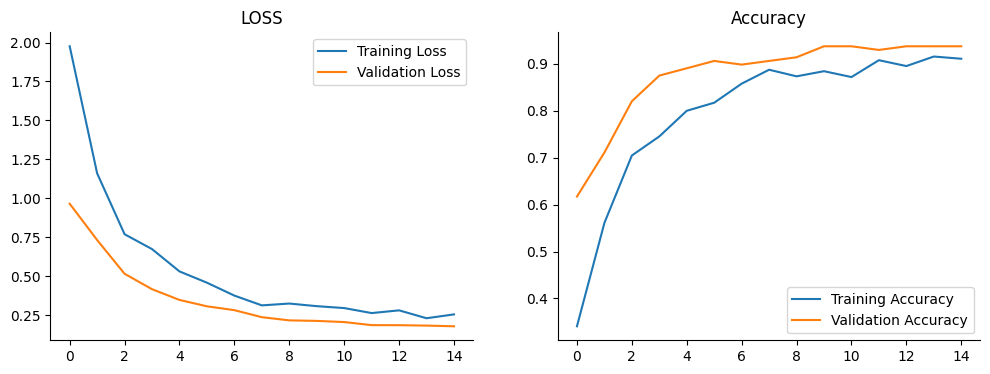

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize = (12, 4))

sns.lineplot(x = range(len(history.history["loss"])),
             y = history.history["loss"], ax = axes[0],
             label = "Training Loss" )
sns.lineplot(x = range(len(history.history["loss"])),
             y = history.history["val_loss"], ax = axes[0],
             label = "Validation Loss")

sns.lineplot(x = range(len(history.history["accuracy"])),
             y = history.history["accuracy"], ax = axes[1],
             label = "Training Accuracy")
sns.lineplot(x = range(len(history.history["accuracy"])),
             y = history.history["val_accuracy"], ax = axes[1],
             label = "Validation Accuracy")
axes[0].set_title("LOSS");axes[1].set_title("Accuracy")

sns.despine()
plt.show()


In [25]:
val_pred = model.predict(val_generator, steps=np.ceil(val_data.shape[0] / batch_size))
val_data["val_pred"] = np.argmax(val_pred, axis=1)

labels = {v: k for k, v in val_generator.class_indices.items()}

val_data["val_pred"] = val_data["val_pred"].map(labels)

3/3 [==============================] - 20s 6s/step


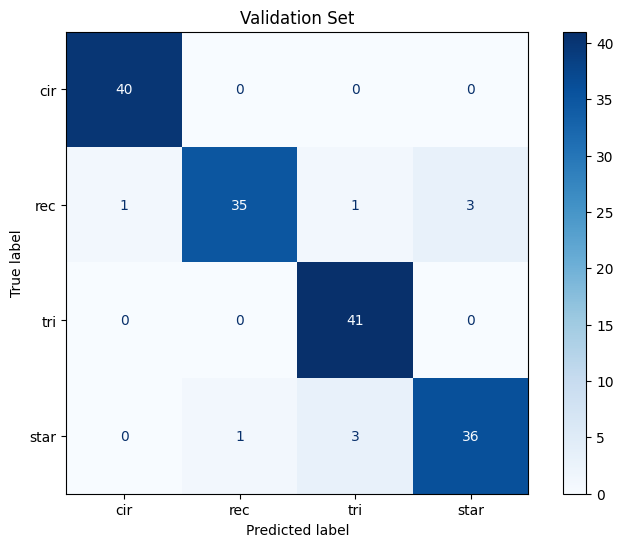

In [21]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize = (9, 6))

cm = confusion_matrix(val_data["label"], val_data["val_pred"])

disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["cir", "rec", "tri", "star"])
disp.plot(cmap = plt.cm.Blues, ax = ax)

ax.set_title("Validation Set")
plt.show()

In [22]:
val_errors = val_data[(val_data.label) != (val_data.val_pred)].reset_index(drop = True)
val_errors

,file,label,val_pred
0,tri_719.jpg,tri,star
1,tri_1000021.jpg,tri,rec
2,rec_661.jpg,rec,cir
3,rec_5.jpg,rec,tri
4,tri_1000036.jpg,tri,star
5,rec_1000019.jpg,rec,tri
6,rec_1000056.jpg,rec,star
7,rec_655.jpg,rec,tri
8,tri_1000048.jpg,tri,star


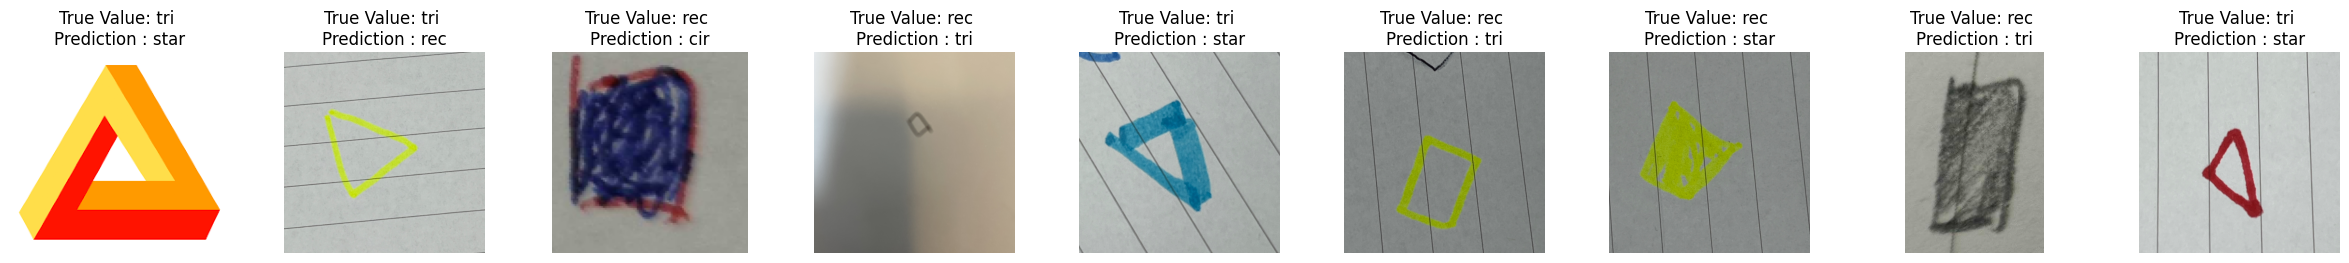

In [26]:
fig = plt.figure(1, figsize = (24, 20))
for i in range(81):
    if i == len(val_errors):
        break
    plt.subplot(9, 9, i + 1)
    image = plt.imread("/home/kkyu/amr_ws/DL/data/shape_figure/train/" + val_errors.file[i])
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"True Value: {val_errors['label'][i]} \nPrediction : {val_errors['val_pred'][i]}")

plt.tight_layout()
plt.show()